In [1]:
import torch
from torch import nn
import pretrainedmodels

from utils.train import train
from utils.evaluation import evaluation
from utils.loader import get_loader, get_image_list
from utils.losses import CostSensitiveRegularizedLoss

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# hyper params
num_of_class = 102
learning_rate = 1e-03
batch_size = 128
input_size = 224
device = torch.device("cuda")
test_size = 0.2
train_size = 0.7
val_size = 0.1
directoryAgeDB = 'AgeDB/'

In [3]:
def findAge(image_list):
    listofzeros = [0] * 102
    same_age = [i for i in range(0, 102)]
    age_number = dict(zip(same_age, listofzeros))
    sum = 0

    for i in range(len(image_list)):

        if image_list[i]['age'] in age_number:
            age_number[image_list[i]['age']] += 1
            sum += 1

    print(sum)
    return dict(age_number)


In [4]:
train_image_list, test_image_list, validate_image_list = get_image_list(
    train_size=train_size, 
    test_size=test_size, 
    val_size=val_size, 
    directory=directoryAgeDB,
)

train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=3,
)

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  34623
Test Set Length:  3298
Validation Set Length:  1649
Total:  39570


In [5]:
resnet1 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet1.last_linear = nn.Linear(
    in_features=resnet1.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet2 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet2.last_linear = nn.Linear(
    in_features=resnet2.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet1 = resnet1.to(device)
resnet2 = resnet2.to(device)

In [6]:
from pytorch_metric_learning.losses import ArcFaceLoss
criteria = ArcFaceLoss(num_classes=num_of_class, embedding_size=num_of_class)
optimizer = torch.optim.Adam(resnet1.parameters(), lr=learning_rate, weight_decay=1e-1)
model_name = 'arcface-aug.pth'

Epoch: 1/5, Train Loss: 35.201312399438386,  Validation Loss: 34.7150873037485
Validation Loss Decreased(inf ---> 34.7150873037485)
Epoch: 2/5, Train Loss: 34.671359466890564,  Validation Loss: 34.753018599290115
Epoch: 3/5, Train Loss: 34.665399122062205,  Validation Loss: 34.765874715951774
Epoch: 4/5, Train Loss: 34.648239938095486,  Validation Loss: 34.65152447040264
Validation Loss Decreased(34.7150873037485 ---> 34.65152447040264)
Epoch: 5/5, Train Loss: 34.63194349507124,  Validation Loss: 34.626349229079025
Validation Loss Decreased(34.65152447040264 ---> 34.626349229079025)


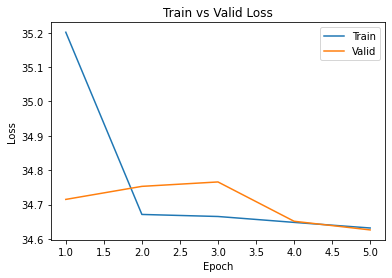

In [7]:
train(resnet1, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [8]:
resnet1.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet1, test_loader)
_ = evaluation(resnet1, train_loader)

Mean Absolute Error: 34.773197174072266
Minimum: 0.0, Maximum: 91.0, Median: 33.0
Mean Absolute Error: 34.285762786865234
Minimum: 0.0, Maximum: 85.0, Median: 33.0


In [9]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 9.00
2  No Sample
3 : 2 : 33.00
4 : 1 : 58.00
5 : 1 : 57.00
6 : 2 : 56.00
7 : 2 : 55.00
8 : 2 : 54.00
9 : 1 : 53.00
10 : 3 : 52.00
11 : 4 : 51.00
12 : 3 : 50.00
13 : 4 : 49.00
14 : 5 : 39.20
15 : 9 : 42.33
16 : 10 : 46.00
17 : 16 : 45.00
18 : 24 : 42.50
19 : 22 : 38.36
20 : 32 : 42.00
21 : 33 : 38.27
22 : 37 : 39.24
23 : 42 : 37.76
24 : 52 : 34.31
25 : 57 : 35.07
26 : 55 : 33.09
27 : 61 : 32.64
28 : 69 : 32.61
29 : 62 : 31.42
30 : 77 : 30.13
31 : 63 : 30.05
32 : 75 : 28.51
33 : 67 : 28.01
34 : 72 : 27.00
35 : 82 : 26.73
36 : 69 : 26.00
37 : 74 : 25.59
38 : 76 : 24.74
39 : 64 : 25.06
40 : 77 : 24.29
41 : 64 : 22.56
42 : 71 : 24.06
43 : 65 : 23.74
44 : 56 : 23.14
45 : 68 : 22.82
46 : 57 : 25.82
47 : 58 : 24.48
48 : 62 : 24.45
49 : 53 : 26.25
50 : 63 : 28.00
51 : 57 : 27.84
52 : 62 : 29.61
53 : 50 : 28.04
54 : 51 : 32.00
55 : 59 : 26.97
56 : 45 : 30.00
57 : 49 : 31.57
58 : 49 : 30.04
59 : 43 : 38.30
60 : 49 : 39.22
61 : 41 : 32.71
62 : 48 : 40.08
63 : 4

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  11541
Test Set Length:  3298
Validation Set Length:  1649
Total:  16488
Epoch: 1/5, Train Loss: 35.89144813621437,  Validation Loss: 35.05999433077299
Validation Loss Decreased(inf ---> 35.05999433077299)
Epoch: 2/5, Train Loss: 34.8962156694014,  Validation Loss: 34.92177170973558
Validation Loss Decreased(35.05999433077299 ---> 34.92177170973558)
Epoch: 3/5, Train Loss: 34.83866391863142,  Validation Loss: 34.954393533559944
Epoch: 4/5, Train Loss: 34.81714957101004,  Validation Loss: 34.862227806678185
Validation Loss Decreased(34.92177170973558 ---> 34.862227806678185)
Epoch: 5/5, Train Loss: 34.763563135168056,  Validation Loss: 34.95765598003681


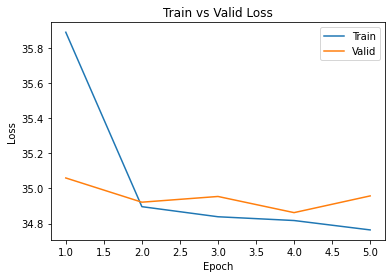

In [10]:
train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=1,
)
criteria = ArcFaceLoss(num_classes=num_of_class, embedding_size=num_of_class)
optimizer = torch.optim.Adam(resnet2.parameters(), lr=learning_rate, weight_decay=1e-1)
model_name = 'arcface.pth'
train(resnet2, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [11]:
resnet2.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet2, test_loader)
_ = evaluation(resnet2, train_loader)

Mean Absolute Error: 48.805335998535156
Minimum: 0.0, Maximum: 98.0, Median: 51.0
Mean Absolute Error: 48.44320297241211
Minimum: 0.0, Maximum: 98.0, Median: 51.0


In [12]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 23.00
2  No Sample
3 : 2 : 59.50
4 : 1 : 97.00
5 : 1 : 96.00
6 : 2 : 95.00
7 : 2 : 94.00
8 : 2 : 93.00
9 : 1 : 92.00
10 : 3 : 91.00
11 : 4 : 70.75
12 : 3 : 89.00
13 : 4 : 88.00
14 : 5 : 56.20
15 : 9 : 68.89
16 : 10 : 85.00
17 : 16 : 74.38
18 : 24 : 76.58
19 : 22 : 75.00
20 : 32 : 68.97
21 : 33 : 63.67
22 : 37 : 66.51
23 : 42 : 68.83
24 : 52 : 65.15
25 : 57 : 65.47
26 : 55 : 61.73
27 : 61 : 62.36
28 : 69 : 63.00
29 : 62 : 62.27
30 : 77 : 60.87
31 : 63 : 51.00
32 : 75 : 58.43
33 : 67 : 53.91
34 : 72 : 46.42
35 : 82 : 53.26
36 : 69 : 52.71
37 : 74 : 49.53
38 : 76 : 52.68
39 : 64 : 47.31
40 : 77 : 42.88
41 : 64 : 47.23
42 : 71 : 45.72
43 : 65 : 43.60
44 : 56 : 45.77
45 : 68 : 42.10
46 : 57 : 39.37
47 : 58 : 44.91
48 : 62 : 38.97
49 : 53 : 38.25
50 : 63 : 37.51
51 : 57 : 37.49
52 : 62 : 37.15
53 : 50 : 35.84
54 : 51 : 36.00
55 : 59 : 37.36
56 : 45 : 37.78
57 : 49 : 38.39
58 : 49 : 37.49
59 : 43 : 37.28
60 : 49 : 37.53
61 : 41 : 38.32
62 : 48 : 38.33
63 : 